# Question 2: Using Bootstrap to Evaluate Drug Bioequivalence

In [1]:
import pandas as pd
df = pd.read_csv('bioequivalence.csv')
df

,Patient,New Drug,Old Drug,Placebo
0,0,16449,17649,9243
1,1,14614,12013,9671
2,2,17274,19979,11792
3,3,23798,21816,13357
4,4,12560,13850,9055
5,5,10157,9806,6290
6,6,16570,17208,12412
7,7,26325,29044,18806


## 2a

In [2]:
import numpy as np
n_o = np.mean(df['New Drug'] - df['Old Drug'])
o_p = np.mean(df['Old Drug'] - df['Placebo'])
theta_hat = n_o / o_p
print("theta estimate:", theta_hat)

theta estimate: -0.07130609590256017


## 2bi

In [3]:
def bootstrap_bioequivalence(N, O, P, B):
    theta_hats = []
    df2 = pd.DataFrame({'New': N, 'Old': O, 'Placebo': P})
    for i in np.arange(B):
        bootstrap = df2.sample(len(df2), replace = True)
        theta_hat = np.mean(bootstrap['New'] - bootstrap['Old']) / np.mean(bootstrap['Old'] - bootstrap['Placebo'])
        theta_hats.append(theta_hat)
    return theta_hats


##  2bii

In [4]:
import matplotlib.pyplot as plt
estimates = bootstrap_bioequivalence(df['New Drug'], df['Old Drug'], df['Placebo'], 10000)
plt.hist(estimates)
plt.xlabel('Estimated Thetas')
plt.ylabel('Frequency')
plt.title('Theta Estimates Histogram');

## 2biii

In [5]:
lower_bound = np.percentile(estimates, 2.5)
upper_bound = np.percentile(estimates, 97.5)
print("95% CI: (", lower_bound, ",", upper_bound, ")")


95% CI: ( -0.233986434091652 , 0.16455620215633085 )


### 2c

We cannot conclude that the new drug and old drug are bioequivalent at the 95% confidence level because our confidence interval, (-0.235933924709275, 0.15949001386224662), does not satisfy |theta| <= 0.2, which is the FDA requirement for bioequivalence.

# Question 3

## 3a

In [6]:
import pickle as pkl
X = np.load('X.pkl', allow_pickle=True)
X.shape

(962, 1200)

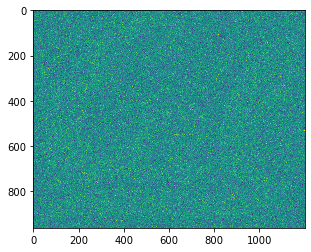

In [7]:
plt.imshow(X)

## 3b

 Initialize $Z^{(0)} = X$


 For $t = 1,..., T$:

- Sample $Z_{1,1}^{(t)} \sim p(Z_{1,1} | Z_{1,2} = Z_{1,2}^{(t-1)}, Z_{1,3} = Z_{1,3}^{(t-1)},..., Z_{n,m} = Z_{n,m}^{(t-1)}, X)$ 


- Sample $Z_{1,2}^{(t)} \sim p(Z_{1,2} | Z_{1,1} = Z_{1,1}^{(t)}, Z_{1,3} = Z_{1,3}^{(t-1)},..., Z_{n,m} = Z_{n,m}^{(t-1)}, X)$ 


- Sample $Z_{1,3}^{(t)} \sim p(Z_{1,3} | Z_{1,1} = Z_{1,1}^{(t)}, Z_{1,2} = Z_{1,2}^{(t)}, Z_{1,4} = Z_{1,4}^{(t-1)},..., Z_{n,m} = Z_{n,m}^{(t-1)}, X)$ 


- $...$


- Sample $Z_{n,m}^{(t)} \sim p(Z_{n,m} | Z_{1,1} = Z_{1,1}^{(t)}, Z_{1,2} = Z_{1,2}^{(t)},..., Z_{n,m-1} = Z_{n,m-1}^{(t)}, X)$ 


## 3c


Initialize $Z^{(0)} = X$

For $t = 1,..., T$:

* For $I = 1,...,i$:

    * For $J = 1,...,j$:
        
        * $S_{I,J} = \sum_{(I',J')\in N_{(I,J)}} Z_{I'J'}$
        
        * Sample $Z_{I,J}^{(t)} \sim N(\frac{\tau X_{I,J} + b S_{IJ}}{a + \tau} , \frac{1}{a + \tau})$ using $\frac{\tau X_{I,J} + b S_{IJ}}{a + \tau} + \frac{1}{a + \tau} * np.random.randn()$ 
        
        * Let $Z_{I,J}^{(t+1)} = Z_{I,J}^{(t)}$
       

## 3d

In [8]:
neighbors = lambda x, y : [(x2, y2) for x2 in range(x-1, x+2)
                               for y2 in range(y-1, y+2)
                               if (((x2 == x and np.abs(y2-y) == 1) or
                                  (y2 == y and np.abs(x2-x) == 1)) and
                                  (-1 < x2 < 962) and
                                  (-1 < y2 < 1200))]
def sum_neighbors(i, j, Z):
    s = 0
    neighbor = neighbors(i, j)
    for x in neighbor:
        s+=Z[x[0]][x[1]]
    return s

def conditional(a, b, t, x_ij, s):
    sigma = 1 / (a+t)
    mu = ((t*x_ij) + (b*s)) / (a+t)
    return mu + sigma * np.random.randn()
    
def gibs_sampler(a, b, t, T):
    Z_0 = X
    for x in range(T):
        for i in range(Z_0.shape[0]):
            for j in range(Z_0.shape[1]):
                s = sum_neighbors(i, j, Z_0)
                c = conditional(a, b, t, X[i][j], s)
                Z_0[i][j] = c
    return Z_0


                
              
        

Total execution time: 16.465526580810547 seconds


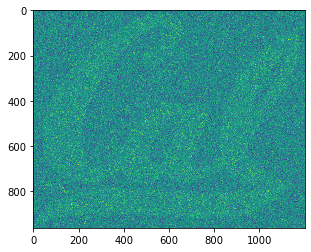

In [9]:
import time
start_time = time.time()
k = gibs_sampler(250, 62.5, 0.01, 1)
plt.imshow(k);
end_time = time.time()
print("Total execution time: {} seconds".format(end_time - start_time))

My code took roughly 19 seconds to run for T=1 iteration so it will probably take 100*19 = 1900 seconds or roughly 32 minutes to run T = 100 iterations.

## 2e

In [10]:
import numpy as np
from scipy.signal import convolve2d
kernel = np.array([[0, 1, 0],
                    [1, 0, 1],
                    [0, 1, 0]])

A = np.zeros(shape=(X.shape[0],X.shape[1]))
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        if (i+j) % 2 == 0:
            A[i][j] = 1
A

array([[1., 0., 1., ..., 0., 1., 0.],
       [0., 1., 0., ..., 1., 0., 1.],
       [1., 0., 1., ..., 0., 1., 0.],
       ...,
       [0., 1., 0., ..., 1., 0., 1.],
       [1., 0., 1., ..., 0., 1., 0.],
       [0., 1., 0., ..., 1., 0., 1.]])

In [11]:
evens = []
odds = []
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        if (i+j) % 2 == 0:
            evens.append((i,j))
        else:
            odds.append((i,j))

In [12]:
def blocked_gibbs(a, b, t, T):
    Z_0 = X.copy()
    for x in range(T):
        Z = Z_0
        delta = (1 / (a+t)) * np.random.randn(X.shape[0], X.shape[1])
        s = convolve2d(Z, kernel, mode='same')
        Z[A==1] =((t/(t+a)) * X[A==1]) + ((b/(t+a))*s[A==1]) + delta[A==1]
        Z[A==0] =((t/(t+a)) * X[A==0]) + ((b/(t+a))*s[A==0]) + delta[A==0]
        Z_0 = Z
    return Z_0

Equation 16 is the conditional distribution of a single pixel $Z_{ij}$ given the other pixels. In blocked Gibbs sampling, we sample from the full posterior, $p(Z_{I_{even}}, Z_{I_{odd}} | X)$ by alternating between the conditional distribution of $Z_{I_{even}}$ conditioned on $Z_{I_{odd}}$, $p(Z_{I_{even}} | Z_{I_{odd}}, X)$, and $Z_{I_{odd}}$ conditioned on $Z_{I_{even}}$, $p(Z_{I_{odd}} | Z_{I_{even}}, X)$. We are able to do this because for any given pixel, its conditional distribution depends on its neighbors, $N(i, j)$. Since the neighbors of even pixels are odd pixels and the neighbors of odd pixels are even pixels, even/odd pixels are independent of each other conditioned on the other type (even/odd), and thus we can calculate $p(Z_{I_{even}}, Z_{I_{odd}} | X)$ by alternating between the conditional distributions of $p(Z_{I_{even}} | Z_{I_{odd}}, X)$ and $p(Z_{I_{odd}} | Z_{I_{even}}, X)$.

## 3f

In [13]:
start_time = time.time()
f = blocked_gibbs(250, 62.5, 0.01, 100)
end_time = time.time()
print("Total execution time: {} seconds".format(end_time - start_time))

Total execution time: 15.548336505889893 seconds


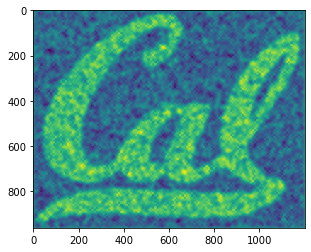

In [14]:
plt.imshow(f);